<a href="https://colab.research.google.com/github/ShimilSBabu/Siamese-Network-for-Face-Recognition/blob/main/siamese_network_fetch_olivetti_faces_v_1_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing Libs

In [4]:
from sklearn.datasets import fetch_olivetti_faces
from numpy.random import RandomState
import numpy as np
import cv2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten, Dropout, GlobalAveragePooling2D, Lambda
import tensorflow as tf
import tensorflow.keras.backend as k
from tensorflow.keras.utils import plot_model
import matplotlib.pyplot as plt
from datetime import datetime

# Display Images

In [70]:
# def display_images(image):
#   plt.figure()
#   plt.imshow(image)
#   plt.colorbar()
#   plt.grid(False)
#   plt.show()

def display_images(image1, image2):
  f, axarr = plt.subplots(1,2)
  # plt.figure()
  axarr[0].imshow(image1)
  axarr[1].imshow(image2)
  # plt.colorbar()
  plt.grid(False)
  plt.show()

# Model Defenition

In [6]:
def create_model():
    inputs = Input((64, 64, 1))
    x = Conv2D(96, (11, 11), padding="same", activation="relu")(inputs)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.3)(x)

    x = Conv2D(256, (5, 5), padding="same", activation="relu")(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.3)(x)

    x = Conv2D(384, (3, 3), padding="same", activation="relu")(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.3)(x)

    pooledOutput = GlobalAveragePooling2D()(x)
    pooledOutput = Dense(1024)(pooledOutput)
    outputs = Dense(128)(pooledOutput)

    model = Model(inputs, outputs)
    return model

# Feature Extractor

In [7]:
feature_extractor = create_model()
imgA = Input(shape=(64, 64, 1))
imgB = Input(shape=(64, 64, 1))
featA = feature_extractor(imgA)
featB = feature_extractor(imgB)

# Function to Calculate Euclidian Distance

In [8]:
def euclidean_distance(vectors):
    (featA, featB) = vectors
    sum_squared = k.sum(k.square(featA - featB), axis=1, keepdims=True)
    return k.sqrt(k.maximum(sum_squared, k.epsilon()))

distance = Lambda(euclidean_distance)([featA, featB])
outputs = Dense(1, activation="sigmoid")(distance)
model = Model(inputs=[imgA, imgB], outputs=outputs)

# Compiling the Model

In [9]:
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

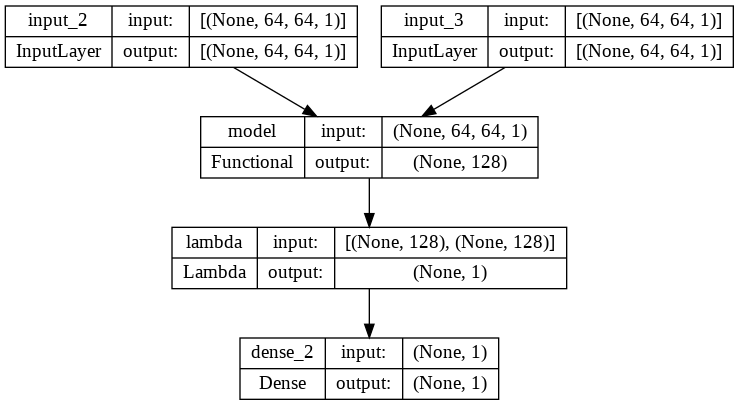

In [10]:
plot_model(model, show_shapes=True, show_layer_names=True, to_file='model.png')

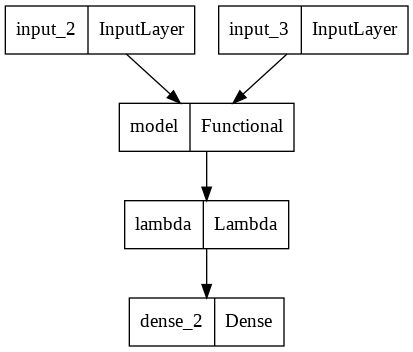

In [11]:
plot_model(model)

# Importing the Dataset

In [41]:
rng = RandomState(0)
# images_dataset, labels_dataset = fetch_olivetti_faces(return_X_y=True, shuffle=True, random_state=rng)
data = fetch_olivetti_faces(return_X_y=False, shuffle=True, random_state=rng)
images_dataset = data['images']
labels_dataset = data['target']
# n_samples, n_features = images_dataset.shape

# Training Pairs Generation

In [16]:
def generate_train_image_pairs(images_dataset, labels_dataset):
    unique_labels = np.unique(labels_dataset)
    label_wise_indices = dict()
    for label in unique_labels:
        label_wise_indices.setdefault(label,
                                      [index for index, curr_label in enumerate(labels_dataset) if
                                       label == curr_label])
    
    pair_images = []
    pair_labels = []
    for index, image in enumerate(images_dataset):
        pos_indices = label_wise_indices.get(labels_dataset[index])
        pos_image = images_dataset[np.random.choice(pos_indices)]
        
        image = cv2.resize(image, dsize=(64, 64))
        
        pair_images.append((image, pos_image))
        pair_labels.append(1)

        neg_indices = np.where(labels_dataset != labels_dataset[index])
        neg_image = images_dataset[np.random.choice(neg_indices[0])]
        pair_images.append((image, neg_image))
        pair_labels.append(0)
    # pair_labels = pair_labels.astype('float32')  
    return np.array(pair_images), np.array(pair_labels)

In [42]:
images_pair, labels_pair = generate_train_image_pairs(images_dataset, labels_dataset)

# Display Some Image Pairs

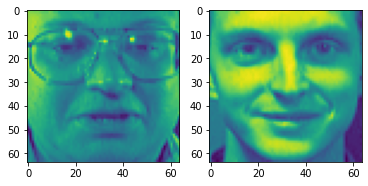

0


In [71]:
image_pair_num = 3
display_images(images_pair[image_pair_num][0], images_pair[image_pair_num][1])
print(labels_pair[image_pair_num])

# Model Training

In [47]:
history = model.fit([images_pair[:, 0], images_pair[:, 1]], labels_pair[:],validation_split=0.1,batch_size=64,epochs=100)

Epoch 1/100
12/12 [==============================] - 13s 155ms/step - loss: 0.6521 - accuracy: 0.5000 - val_loss: 0.6094 - val_accuracy: 0.5750
Epoch 2/100
12/12 [==============================] - 1s 91ms/step - loss: 0.6191 - accuracy: 0.5000 - val_loss: 0.5842 - val_accuracy: 0.5750
Epoch 3/100
12/12 [==============================] - 1s 90ms/step - loss: 0.6041 - accuracy: 0.5028 - val_loss: 0.5810 - val_accuracy: 0.6000
Epoch 4/100
12/12 [==============================] - 1s 90ms/step - loss: 0.6166 - accuracy: 0.5069 - val_loss: 0.5928 - val_accuracy: 0.6250
Epoch 5/100
12/12 [==============================] - 1s 91ms/step - loss: 0.6100 - accuracy: 0.5097 - val_loss: 0.5802 - val_accuracy: 0.6000
Epoch 6/100
12/12 [==============================] - 1s 89ms/step - loss: 0.6042 - accuracy: 0.5389 - val_loss: 0.6041 - val_accuracy: 0.6500
Epoch 7/100
12/12 [==============================] - 1s 90ms/step - loss: 0.5920 - accuracy: 0.5583 - val_loss: 0.6112 - val_accuracy: 0.6375
Epoc

# Testing Pairs Generation

In [54]:
def generate_test_image_pairs(images_dataset, labels_dataset, image):
    unique_labels = np.unique(labels_dataset)
    label_wise_indices = dict()
    for label in unique_labels:
        label_wise_indices.setdefault(label,
                                      [index for index, curr_label in enumerate(labels_dataset) if
                                        label == curr_label])
  
    pair_images = []
    pair_labels = []
    for label, indices_for_label in label_wise_indices.items():
        test_image = images_dataset[np.random.choice(indices_for_label)]
        pair_images.append((image, test_image))
        pair_labels.append(label)
    # pair_labels = pair_labels.astype('float32')  
    return np.array(pair_images), np.array(pair_labels)

# Save Model

In [78]:
current_time = str(datetime.now())[:16].replace(':', '_')
model.save(f'siamese_network_fetch_olivetti_faces_{current_time}.h5')

# Prediction

1/1 [==============================] - 0s 20ms/step


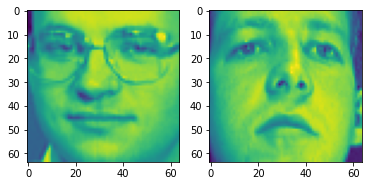

0.18118186 



1/1 [==============================] - 0s 20ms/step


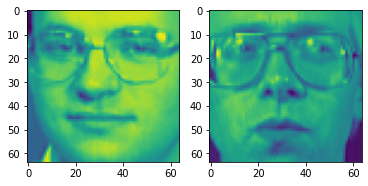

0.28699327 



1/1 [==============================] - 0s 22ms/step


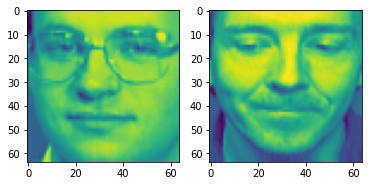

0.695478 



1/1 [==============================] - 0s 25ms/step


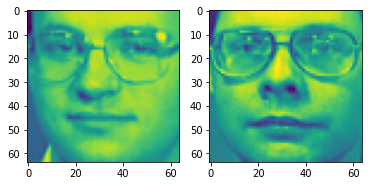

0.58947206 



1/1 [==============================] - 0s 17ms/step


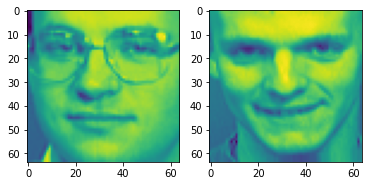

0.6036434 



1/1 [==============================] - 0s 18ms/step


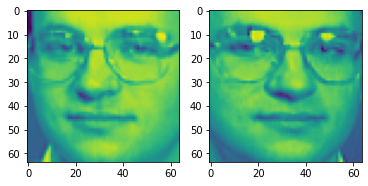

0.6643807 



1/1 [==============================] - 0s 16ms/step


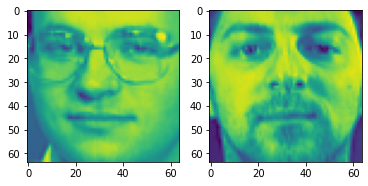

0.31384414 



1/1 [==============================] - 0s 18ms/step


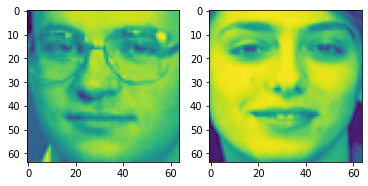

0.03829717 



1/1 [==============================] - 0s 20ms/step


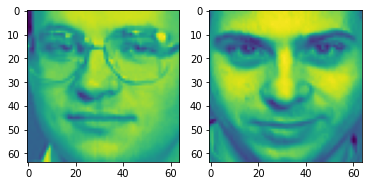

0.6825765 



1/1 [==============================] - 0s 23ms/step


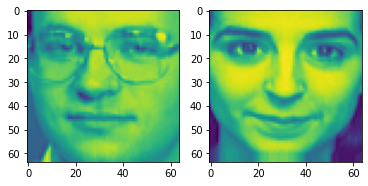

0.051563527 



1/1 [==============================] - 0s 16ms/step


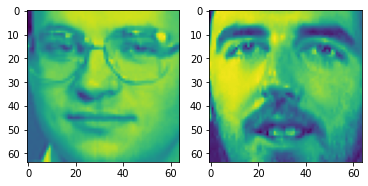

0.13705747 



1/1 [==============================] - 0s 17ms/step


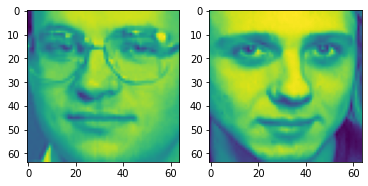

0.1887077 



1/1 [==============================] - 0s 18ms/step


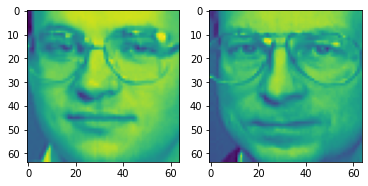

0.65391093 



1/1 [==============================] - 0s 16ms/step


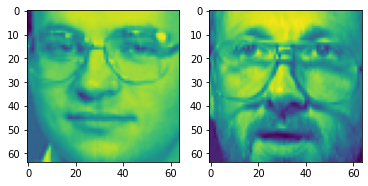

0.3885121 



1/1 [==============================] - 0s 16ms/step


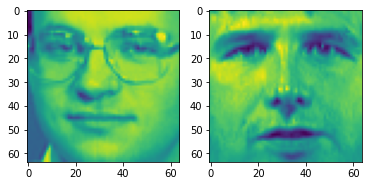

0.68084794 



1/1 [==============================] - 0s 19ms/step


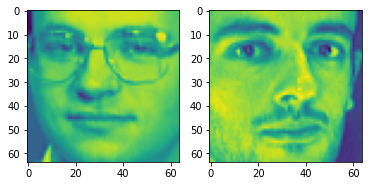

0.39788932 



1/1 [==============================] - 0s 16ms/step


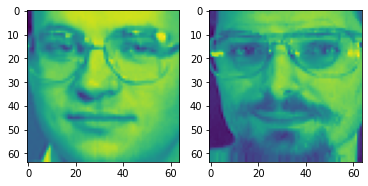

0.58123034 



1/1 [==============================] - 0s 19ms/step


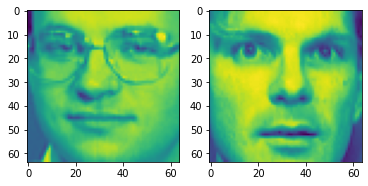

0.5620394 



1/1 [==============================] - 0s 18ms/step


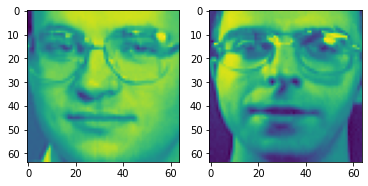

0.09562688 



1/1 [==============================] - 0s 21ms/step


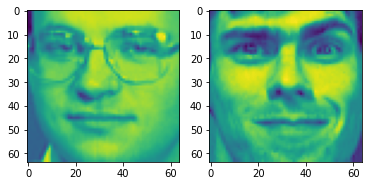

0.6346097 



1/1 [==============================] - 0s 19ms/step


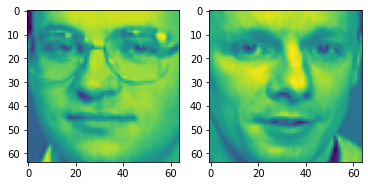

0.19277334 



1/1 [==============================] - 0s 18ms/step


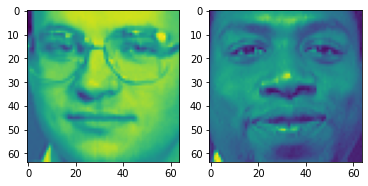

0.17742293 



1/1 [==============================] - 0s 18ms/step


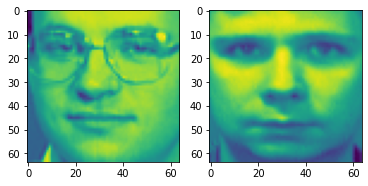

0.65269256 



1/1 [==============================] - 0s 18ms/step


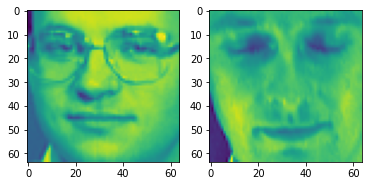

0.3824418 



1/1 [==============================] - 0s 18ms/step


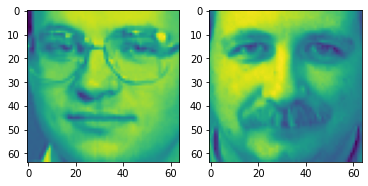

0.67949146 



1/1 [==============================] - 0s 28ms/step


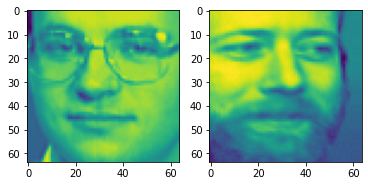

0.5581314 



1/1 [==============================] - 0s 28ms/step


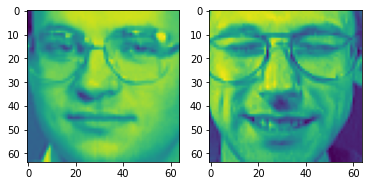

0.06813182 



1/1 [==============================] - 0s 17ms/step


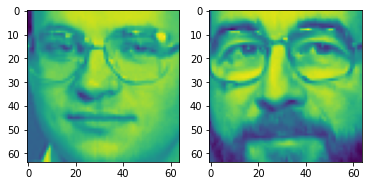

0.11606173 



1/1 [==============================] - 0s 20ms/step


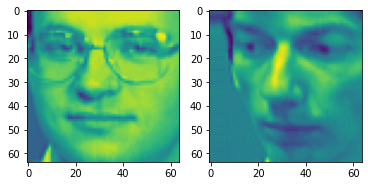

0.33867475 



1/1 [==============================] - 0s 17ms/step


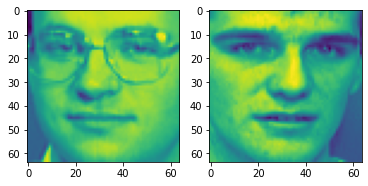

0.5199732 



1/1 [==============================] - 0s 26ms/step


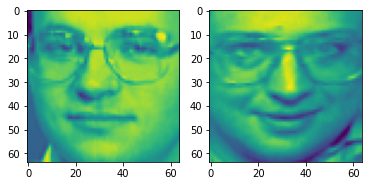

0.34272876 



1/1 [==============================] - 0s 27ms/step


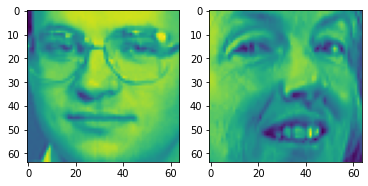

0.4208153 



1/1 [==============================] - 0s 21ms/step


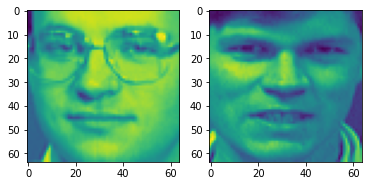

0.32435367 



1/1 [==============================] - 0s 20ms/step


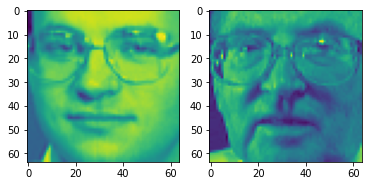

0.38649243 



1/1 [==============================] - 0s 26ms/step


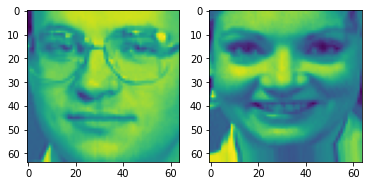

0.5528896 



1/1 [==============================] - 0s 24ms/step


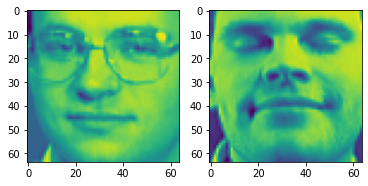

0.35162324 



1/1 [==============================] - 0s 23ms/step


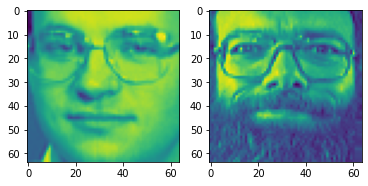

0.3878717 



1/1 [==============================] - 0s 21ms/step


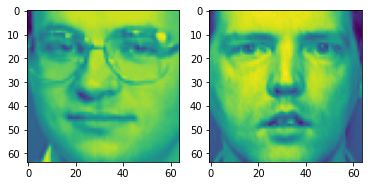

0.533214 



1/1 [==============================] - 0s 22ms/step


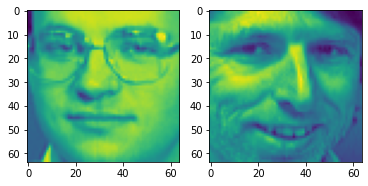

0.24476258 



1/1 [==============================] - 0s 21ms/step


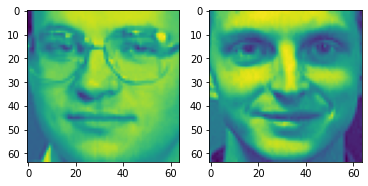

0.58276194 





In [73]:
image = images_dataset[92] # a random image as test image
test_image_pairs, test_label_pairs = generate_test_image_pairs(images_dataset, labels_dataset, image) # produce an array of test image pairs and test label pairs

# for each pair in the test image pair, predict the similarity between the images
for index, pair in enumerate(test_image_pairs):
    pair_image1 = np.expand_dims(pair[0], axis=-1)
    pair_image1 = np.expand_dims(pair_image1, axis=0)
    pair_image2 = np.expand_dims(pair[1], axis=-1)
    pair_image2 = np.expand_dims(pair_image2, axis=0)
    prediction = model.predict([pair_image1, pair_image2])[0][0]
    display_images(pair[0], pair[1])
    print(prediction,'\n'*3)

In [ ]:
model.

Credits :- Girija Shankar Behera

https://medium.com/wicds/face-recognition-using-siamese-networks-84d6f2e54ea4